<a href="https://colab.research.google.com/github/jairorodriguezarias/matching_engine_create_multimodal_embeddings/blob/main/vector_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [1]:
# @title
# Install the packages
! pip3 install --upgrade google-cloud-aiplatform \
                         google-cloud-storage

! pip install google-cloud-vision
! pip install gradio
! pip install typing_extensions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.3/183.3 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.17.3
    Uninstalling google-auth-2.17.3:
      Successfully uninstalled google-auth-2.17.3
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 2.8.0
    Uninstalling google-cloud-storage-2.8.0:
      Successfully uninstalled google-cloud-storage-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
google-colab 1.0.0 requires go

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.1/444.1 kB 5.2 MB/s eta 0:00:00


In [2]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

# Configuration


In [3]:
from google.colab import auth
auth.authenticate_user()

In [7]:
PROJECT_ID = "genai-387907"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


In [8]:
REGION = "us-central1"  # @param {type: "string"}

Cloud Storage

In [17]:
BUCKET_NAME = "vector_store"

In [18]:
BUCKET_URI = f"gs://{BUCKET_NAME}-{PROJECT_ID}-unique"  # @param {type:"string"}

In [ ]:
# Only if your bucket doesn't exist
# ! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

In [9]:
# Create folder in Google Cloud Colab

!mkdir images

In [10]:
# Move the images from a google bucket folder to Colab folder

# It is possible upload images from local computer to Colab Folder manually

!gsutil cp gs://vector_store-genai-387907-images/* ./images

Copying gs://vector_store-genai-387907-images/0000000112_2_1_1.jpg...
Copying gs://vector_store-genai-387907-images/0077307081_6_1_1.jpg...
Copying gs://vector_store-genai-387907-images/0085454807_1_1_1.jpg...
Copying gs://vector_store-genai-387907-images/0264474302_1_1_1.jpg...
- [4 files][  1.9 MiB/  1.9 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://vector_store-genai-387907-images/0310009999_1_1_1.jpg...
Copying gs://vector_store-genai-387907-images/0310274999_6_1_1.jpg...
Copying gs://vector_store-genai-387907-images/0387157052_1_1_1.jpg...
Copying gs://vector_store-genai-387907-images/0475691990_6_1_1.jpg...
Copying gs://vector_store-genai-387907-images/0485561712_6_1_1.jpg...
Copying gs://vector_store-genai-38790

In [9]:
image_directory = "/content"

# Cloud Vision Embeddings

In [10]:
import os

In [11]:
import glob
image_names = glob.glob('images/*.jpg')

In [12]:
# image_directory = "/content/images"
# image_names = ['0478630300_1_1_1.jpg', '0485561712_6_1_1.jpg', '1165680701_1_1_1.jpg']

image_paths = [os.path.join(image_directory, image_name) for image_name in image_names]

print(image_paths)

['/content/images/0310274999_6_1_1.jpg', '/content/images/0000000112_2_1_1.jpg', '/content/images/2582510800_6_1_1.jpg', '/content/images/4369001800_1_1_1.jpg', '/content/images/4087760800_6_1_1.jpg', '/content/images/5643532250_6_1_1.jpg', '/content/images/4805553712_6_1_1.jpg', '/content/images/5070646800_1_1_1.jpg', '/content/images/1608360800_1_1_1.jpg', '/content/images/0077307081_6_1_1.jpg', '/content/images/6917764806_6_1_1.jpg', '/content/images/6029230604_6_1_1.jpg', '/content/images/5048702500_6_1_1.jpg', '/content/images/1716345611_6_1_1.jpg', '/content/images/9929222712_1_1_1.jpg', '/content/images/6771095800_1_1_1.jpg', '/content/images/1880676800_6_1_1.jpg', '/content/images/1538403401_6_1_1.jpg', '/content/images/2108220800_6_1_1.jpg', '/content/images/0518059711_1_1_1.jpg', '/content/images/9000000101_1_1_1.jpg', '/content/images/4424355712_6_1_1.jpg', '/content/images/5420210800_6_1_1.jpg', '/content/images/2888300800_6_1_1.jpg', '/content/images/0085454807_1_1_1.jpg',

**Perform rate-limited explicit image detection**

In [15]:
import time
from concurrent.futures import ThreadPoolExecutor
from typing import Optional

import numpy as np
from tqdm import tqdm

# Create a rate limiter with a limit of 1800 requests per minute
seconds_per_job = 1 / (1800 / 60)


def process_image(image_path: str) -> Optional[bool]:
    try:
        annotation = detect_safe_search(image_path)

        if annotation:
            return convert_annotation_to_safety(safe_search_annotation=annotation)
        else:
            return None
    except Exception:
        return None


# Process images using ThreadPool
is_safe_values_cloud_vision = []
with ThreadPoolExecutor() as executor:
    futures = []
    for img_url in tqdm(image_paths, total=len(image_paths), position=0):
        futures.append(executor.submit(process_image, img_url))
        time.sleep(seconds_per_job)

    for future in futures:
        is_safe_values_cloud_vision.append(future.result())

# Set Nones to False
is_safe_values_cloud_vision = [
    is_safe or False for is_safe in is_safe_values_cloud_vision
]

# Print number of safe images found
print(
    f"Safe images = {np.array(is_safe_values_cloud_vision).sum()} out of {len(is_safe_values_cloud_vision)} images"
)

100%|██████████| 109/109 [00:03<00:00, 29.44it/s]

Safe images = 0 out of 109 images


## Helper functions

Defining encoding functions


In [13]:
import base64
import time
import typing

from google.cloud import aiplatform
from google.protobuf import struct_pb2


class EmbeddingResponse(typing.NamedTuple):
    text_embedding: typing.Sequence[float]
    image_embedding: typing.Sequence[float]


def load_image_bytes(image_uri: str) -> bytes:
    """Load image bytes from a remote or local URI."""
    image_bytes = None
    if image_uri.startswith("http://") or image_uri.startswith("https://"):
        response = requests.get(image_uri, stream=True)
        if response.status_code == 200:
            image_bytes = response.content
    else:
        image_bytes = open(image_uri, "rb").read()
    return image_bytes


class EmbeddingPredictionClient:
    """Wrapper around Prediction Service Client."""

    def __init__(
        self,
        project: str,
        location: str = "us-central1",
        api_regional_endpoint: str = "us-central1-aiplatform.googleapis.com",
    ):
        client_options = {"api_endpoint": api_regional_endpoint}
        # Initialize client that will be used to create and send requests.
        # This client only needs to be created once, and can be reused for multiple requests.
        self.client = aiplatform.gapic.PredictionServiceClient(
            client_options=client_options
        )
        self.location = location
        self.project = project

    def get_embedding(self, text: str = None, image_file: str = None):
        if not text and not image_file:
            raise ValueError("At least one of text or image_file must be specified.")

        # Load image file
        image_bytes = None
        if image_file:
            image_bytes = load_image_bytes(image_file)

        instance = struct_pb2.Struct()
        if text:
            instance.fields["text"].string_value = text

        if image_bytes:
            encoded_content = base64.b64encode(image_bytes).decode("utf-8")
            image_struct = instance.fields["image"].struct_value
            image_struct.fields["bytesBase64Encoded"].string_value = encoded_content

        instances = [instance]
        endpoint = (
            f"projects/{self.project}/locations/{self.location}"
            "/publishers/google/models/multimodalembedding@001"
        )
        response = self.client.predict(endpoint=endpoint, instances=instances)

        text_embedding = None
        if text:
            text_emb_value = response.predictions[0]["textEmbedding"]
            text_embedding = [v for v in text_emb_value]

        image_embedding = None
        if image_bytes:
            image_emb_value = response.predictions[0]["imageEmbedding"]
            image_embedding = [v for v in image_emb_value]

        return EmbeddingResponse(
            text_embedding=text_embedding, image_embedding=image_embedding
        )

Create helper functions to process data in batches

In [36]:
import time
from concurrent.futures import ThreadPoolExecutor
from typing import Callable, Generator, List

from tqdm.auto import tqdm


def generate_batches(
    inputs: List[str], batch_size: int
) -> Generator[List[str], None, None]:
    """
    Generator function that takes a list of strings and a batch size, and yields batches of the specified size.
    """

    for i in range(0, len(inputs), batch_size):
        yield inputs[i : i + batch_size]


API_IMAGES_PER_SECOND = 2


def encode_to_embeddings_chunked(
    process_function: Callable[[List[str]], List[Optional[List[float]]]],
    items: List[str],
    batch_size: int = 1,
) -> List[Optional[List[float]]]:
    """
    Function that encodes a list of strings into embeddings using a process function.
    It takes a list of strings and returns a list of optional lists of floats.
    The data is processed in chunks to prevent out-of-memory errors.
    """

    embeddings_list: List[Optional[List[float]]] = []

    # Prepare the batches using a generator
    batches = generate_batches(items, batch_size)

    seconds_per_job = batch_size / API_IMAGES_PER_SECOND

    with ThreadPoolExecutor() as executor:
        futures = []
        for batch in tqdm(batches, total=len(items) // batch_size, position=0):
            futures.append(executor.submit(process_function, batch))
            time.sleep(seconds_per_job)

        for future in futures:
            embeddings_list.extend(future.result())
    return embeddings_list


Create functions that wrap embedding functions in try-except and retry logic.

In [35]:
import copy
from typing import List, Optional

import numpy as np
import requests
from tenacity import retry, stop_after_attempt

client = EmbeddingPredictionClient(project=PROJECT_ID)


# Use a retry handler in case of failure
@retry(reraise=True, stop=stop_after_attempt(3))
def encode_texts_to_embeddings_with_retry(text: List[str]) -> List[List[float]]:
    assert len(text) == 1

    try:
        return [client.get_embedding(text=text[0], image_file=None).text_embedding]
    except Exception:
        raise RuntimeError("Error getting embedding.")


def encode_texts_to_embeddings(text: List[str]) -> List[Optional[List[float]]]:
    try:
        return encode_texts_to_embeddings_with_retry(text=text)
    except Exception:
        return [None for _ in range(len(text))]


@retry(reraise=True, stop=stop_after_attempt(3))
def encode_images_to_embeddings_with_retry(image_uris: List[str]) -> List[List[float]]:
    assert len(image_uris) == 1

    try:
        return [
            client.get_embedding(text=None, image_file=image_uris[0]).image_embedding
        ]
    except Exception as ex:
        print(ex)
        raise RuntimeError("Error getting embedding.")


def encode_images_to_embeddings(image_uris: List[str]) -> List[Optional[List[float]]]:
    try:
        return encode_images_to_embeddings_with_retry(image_uris=image_uris)
    except Exception as ex:
        print(ex)
        return [None for _ in range(len(image_uris))]


## Genere the embeddings

In [19]:
%%time
# Encode a sample subset of images
image_paths_filtered = list(image_paths)[:1000]
image_embeddings = encode_to_embeddings_chunked(
    process_function=encode_images_to_embeddings, items=image_paths_filtered
)

# Keep only non-None embeddings
indexes_to_keep, image_embeddings = zip(
    *[
        (index, embedding)
        for index, embedding in enumerate(image_embeddings)
        if embedding is not None
    ]
)

print(f"Processed {len(indexes_to_keep)} embeddings successfully")


  0%|          | 0/109 [00:00<?, ?it/s]

Processed 109 embeddings successfully
CPU times: user 1.8 s, sys: 353 ms, total: 2.15 s
Wall time: 55.6 s


## Test de solution

In [20]:
import numpy as np


def dot_product_distance(
    text_embedding: np.ndarray, image_embeddings: np.ndarray
) -> np.ndarray:
    """Compute dot-product distance between text and image embeddings by taking the dot product"""
    return np.dot(text_embedding, image_embeddings.T)


<class 'list'>
<class 'float'>
<class 'tuple'>
<class 'list'>


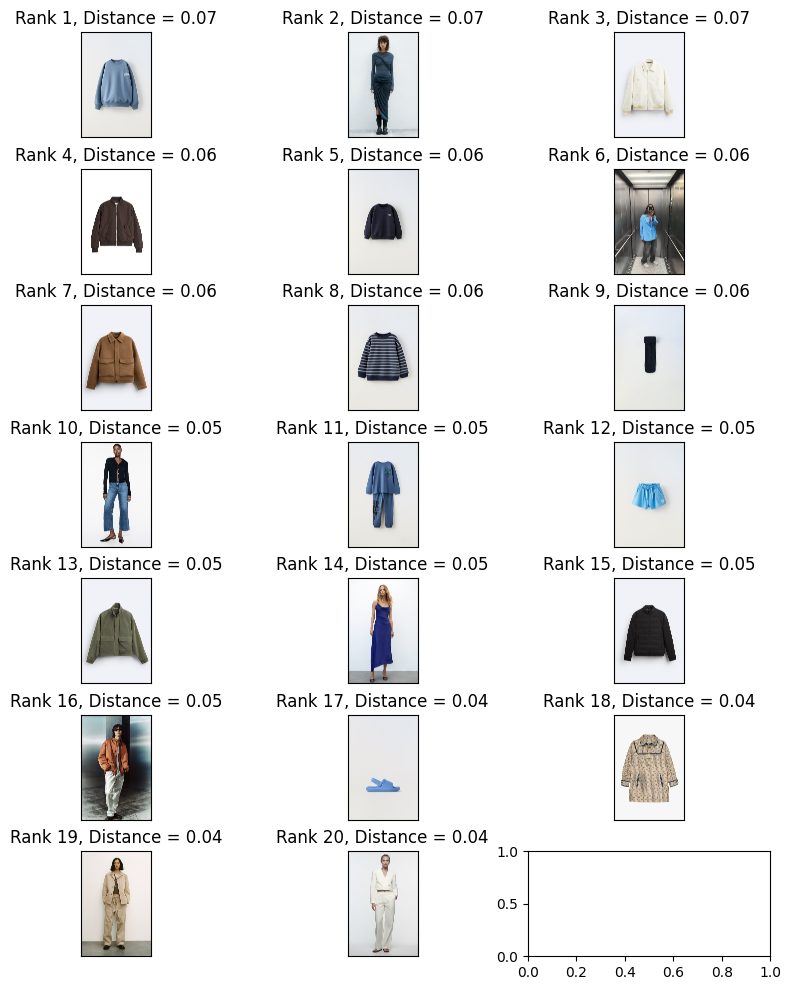

In [23]:
import math
from io import BytesIO

import matplotlib.pyplot as plt
from PIL import Image

text_query = "jacket blue"  # @param {type: "string"}

# Calculate text embedding of query
text_embedding = encode_texts_to_embeddings(text=[text_query])[0]

print(type(text_embedding))
print(type(text_embedding[0]))

print(type(image_embeddings))
print(type(image_embeddings[0]))

# Calculate distance
distances = dot_product_distance(
    text_embedding=np.array(text_embedding), image_embeddings=np.array(image_embeddings)
)

# Set the maximum number of images to display
MAX_IMAGES = 20

# Sort images and scores by descending order of scores and select the top max_images
sorted_data = sorted(
    zip(image_paths_filtered, distances), key=lambda x: x[1], reverse=True
)[:MAX_IMAGES]

# Calculate the number of rows and columns needed to display the images
num_cols = 3
num_rows = math.ceil(len(sorted_data) / num_cols)


# Create a grid of subplots to display the images
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))

# Loop through the top max_images images and display them in the subplots
for i, (image_path, distance) in enumerate(sorted_data):
    # Calculate the row and column index for the current image
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Check if image_path is a remote URL
    if image_path.startswith("http://") or image_path.startswith("https://"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)

    # Display the image in the current subplot
    axs[row_idx, col_idx].imshow(image, cmap="gray")

    # Set the title of the subplot to the image index and score
    axs[row_idx, col_idx].set_title(f"Rank {i+1}, Distance = {distance:.2f}")

    # Remove ticks from the subplot
    axs[row_idx, col_idx].set_xticks([])
    axs[row_idx, col_idx].set_yticks([])

# Adjust the spacing between subplots and display the plot
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

# Deploy Cloud solution

## Process the embeddings

In [24]:
DIMENSIONS = len(text_embedding)

print(DIMENSIONS)

1408


Save the embedding in JSONL formt

In [25]:
import tempfile

# Create temporary file to write embeddings to
embeddings_file = tempfile.NamedTemporaryFile(suffix=".json", delete=False)

embeddings_file.name

'/tmp/tmp0zsl7cfl.json'

Add random restrictions to the images

In [26]:
import json
import random

BATCH_SIZE = 1000


mylist = ["verano", "rebajas"]


with open(embeddings_file.name, "a") as f:
    for i in tqdm(range(0, len(image_names), BATCH_SIZE)):
        image_names_chunk = image_names[i : i + BATCH_SIZE]
        image_paths_chunk = image_paths[i : i + BATCH_SIZE]

        embeddings = encode_to_embeddings_chunked(
            process_function=encode_images_to_embeddings, items=image_paths_chunk
        )

        # Append to file
        embeddings_formatted = [
            json.dumps(
                {
                    "id": str(id),
                    "embedding": [str(value) for value in embedding],
                    "restricts": [
                        {
                           "namespace": "class",
                           "allow": [random.choice(mylist)]
                       }
                ],
            }
        )
            + "\n"
            for id, embedding in zip(image_names_chunk, embeddings)
            if embedding is not None
        ]
        print(embeddings_formatted)
        f.writelines(embeddings_formatted)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

['{"id": "images/0310274999_6_1_1.jpg", "embedding": ["0.0054247356", "-0.00195090706", "-0.0164334", "0.0100975307", "-0.0647175387", "-0.02576093", "-0.0141706616", "0.0173214", "0.0112870326", "0.0502837263", "0.0440827", "-0.0140612014", "0.0211045463", "0.118128739", "-0.0394170582", "0.0318928398", "-0.0204964392", "-0.00317286607", "-0.00610552775", "-0.0328921713", "0.124540672", "0.0490055345", "-0.00558037404", "0.0150420107", "0.000199965885", "-0.0244609695", "0.0264033154", "0.0102068959", "-0.0229144674", "-0.0648041442", "0.0496273562", "0.0060362271", "-0.00320713408", "0.0261297785", "0.00820820872", "-0.0125771603", "-0.0349545851", "0.027868852", "0.00305815553", "-0.0198430065", "-0.00548335724", "0.0286244676", "0.0192975812", "-0.0286244322", "-0.0249028467", "-0.00443218276", "-0.0257730484", "-0.00168974872", "-0.000231545549", "-0.00301502808", "0.000365880755", "0.008432501", "0.00178064744", "0.0104324454", "0.013933179", "-0.00942674186", "-0.0028648423", "-

Upload the training data to Cloud Storage

In [27]:
print(embeddings_file.name)

/tmp/tmp0zsl7cfl.json


Upload the embeddings to GCP

In [33]:
UNIQUE_FOLDER_NAME = "embeddings_folder_unique"
EMBEDDINGS_INITIAL_URI = f"{BUCKET_URI}/{UNIQUE_FOLDER_NAME}/"
! gsutil rm -r {EMBEDDINGS_INITIAL_URI}
print(EMBEDDINGS_INITIAL_URI)
! gsutil cp {embeddings_file.name} {EMBEDDINGS_INITIAL_URI}

CommandException: No URLs matched: gs://vector_store-genai-387907-unique/embeddings_folder_unique/
gs://vector_store-genai-387907-unique/embeddings_folder_unique/
Copying file:///tmp/tmp0zsl7cfl.json [Content-Type=application/json]...
- [1 files][  2.4 MiB/  2.4 MiB]                                                
Operation completed over 1 objects/2.4 MiB.                                      


## Vector Store solution

### Create INDEX. ANN

In [34]:
DIMENSIONS = len(text_embedding)
DISPLAY_NAME = "multimodal_images_allow"
DESCRIPTION = "Multimodal Images Embeddings Allow"

In [19]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

Create the index configuration

Save the train split in JSONL format.
The data must be formatted in JSONL format, which means each embedding dictionary is written as a JSON string on its own line.

Additionally, to demonstrate the filtering functionality, the restricts key is set such that each embedding has a different class, verano or rebajas. These are used during the later matching step to filter for results. See additional information of filtering here: https://cloud.google.com/vertex-ai/docs/matching-engine/filtering

In [36]:
tree_ah_index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
    display_name=DISPLAY_NAME,
    contents_delta_uri=EMBEDDINGS_INITIAL_URI,
    dimensions=DIMENSIONS,
    approximate_neighbors_count=10,
    distance_measure_type="COSINE_DISTANCE",
    # distance_measure_type="DOT_PRODUCT_DISTANCE",
    # distance_measure_type="SQUARED_L2_DISTANCE",
    leaf_node_embedding_count=10,
    leaf_nodes_to_search_percent=7,
    description="Image Index",
    labels={"label_name": "label_value"},
)

INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:Creating MatchingEngineIndex
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:Create MatchingEngineIndex backing LRO: projects/899604603048/locations/us-central1/indexes/1411179193785384960/operations/8585392990501994496
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:MatchingEngineIndex created. Resource name: projects/899604603048/locations/us-central1/indexes/1411179193785384960
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:To use this MatchingEngineIndex in another session:
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:index = aiplatform.MatchingEngineIndex('projects/899604603048/locations/us-central1/indexes/1411179193785384960')


In [33]:
INDEX_RESOURCE_NAME = tree_ah_index.resource_name
INDEX_RESOURCE_NAME

# INDEX_RESOURCE_NAME = "projects/899604603048/locations/us-central1/indexes/1411179193785384960"

'projects/899604603048/locations/us-central1/indexes/1411179193785384960'

Name

In [22]:
tree_ah_index = aiplatform.MatchingEngineIndex(index_name=INDEX_RESOURCE_NAME)

### Create an IndexEndpoint

In [39]:
my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
    display_name=DISPLAY_NAME,
    description=DISPLAY_NAME,
    public_endpoint_enabled=True,
)

INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:Creating MatchingEngineIndexEndpoint
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:Create MatchingEngineIndexEndpoint backing LRO: projects/899604603048/locations/us-central1/indexEndpoints/8970471168326762496/operations/8412004404848230400
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:MatchingEngineIndexEndpoint created. Resource name: projects/899604603048/locations/us-central1/indexEndpoints/8970471168326762496
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:To use this MatchingEngineIndexEndpoint in another session:
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:index_endpoint = aiplatform.MatchingEngineIndexEndpoint('projects/899604603048/locations/us-central1/indexEndpoints/8970471168326762496')


### Deploy Indexes

In [27]:
DEPLOYED_INDEX_ID = "deployed_index_id_unique_allow"

DEPLOYED_INDEX_ID

'deployed_index_id_unique_allow'

In [43]:
my_index_endpoint = my_index_endpoint.deploy_index(
    index=tree_ah_index, deployed_index_id=DEPLOYED_INDEX_ID
)

my_index_endpoint.deployed_indexes

INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:Deploying index MatchingEngineIndexEndpoint index_endpoint: projects/899604603048/locations/us-central1/indexEndpoints/8970471168326762496
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:Deploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/899604603048/locations/us-central1/indexEndpoints/8970471168326762496/operations/9022242154356932608
INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:MatchingEngineIndexEndpoint index_endpoint Deployed index. Resource name: projects/899604603048/locations/us-central1/indexEndpoints/8970471168326762496


[id: "deployed_index_id_unique_allow"
index: "projects/899604603048/locations/us-central1/indexes/1411179193785384960"
create_time {
  seconds: 1700570552
  nanos: 6242000
}
index_sync_time {
  seconds: 1700571462
  nanos: 863040000
}
automatic_resources {
  min_replica_count: 2
  max_replica_count: 2
}
deployment_group: "default"
]

Verify number of items

In [31]:
number_of_vectors = sum(
    aiplatform.MatchingEngineIndex(
        deployed_index.index
    )._gca_resource.index_stats.vectors_count
    for deployed_index in my_index_endpoint.deployed_indexes
)

print(f"Actual: {number_of_vectors}")

AttributeError: ignored

## Test Online Queries

After you built your indexes, you may query against the deployed index through the online querying gRPC API (Match service) within the virtual machine instances from the same region (for example 'us-central1' in this tutorial).

The filter parameter is an optional way to filter for a subset of embeddings. In this case, only embeddings that have the class set as **verano** or **rebajas** are returned.

In [57]:
text_query = "jeans red"  # @param {type: "string"}

test_embeddings = encode_texts_to_embeddings(text=[text_query])

In [58]:
# Test query
from google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint import Namespace

# Test query
NUM_NEIGHBOURS = 20

response = my_index_endpoint.find_neighbors(
    deployed_index_id=DEPLOYED_INDEX_ID,
    queries=test_embeddings,
    num_neighbors=NUM_NEIGHBOURS,
    filter=[Namespace("class", ["rebajas"])],
#    filter=[Namespace("class", ["verano"])],
)
response

[[MatchNeighbor(id='images/9878177800_1_1_1.jpg', distance=0.944040060043335),
  MatchNeighbor(id='images/6164179427_1_1_1.jpg', distance=0.9514634013175964),
  MatchNeighbor(id='images/2893108704_1_1_1.jpg', distance=0.9614231586456299),
  MatchNeighbor(id='images/9000000101_1_1_1.jpg', distance=0.9639665484428406),
  MatchNeighbor(id='images/0310274999_6_1_1.jpg', distance=0.9677638411521912),
  MatchNeighbor(id='images/8432361307_1_1_1.jpg', distance=0.9679831266403198),
  MatchNeighbor(id='images/1165680701_1_1_1.jpg', distance=0.9733195304870605),
  MatchNeighbor(id='images/0000000112_2_1_1.jpg', distance=0.9812979102134705),
  MatchNeighbor(id='images/0310009999_1_1_1.jpg', distance=0.9824169278144836),
  MatchNeighbor(id='images/4548234303_1_1_1.jpg', distance=0.9866960048675537),
  MatchNeighbor(id='images/0518059711_1_1_1.jpg', distance=0.9871262311935425),
  MatchNeighbor(id='images/4087760800_6_1_1.jpg', distance=0.99229896068573),
  MatchNeighbor(id='images/0653786630_6_1_1

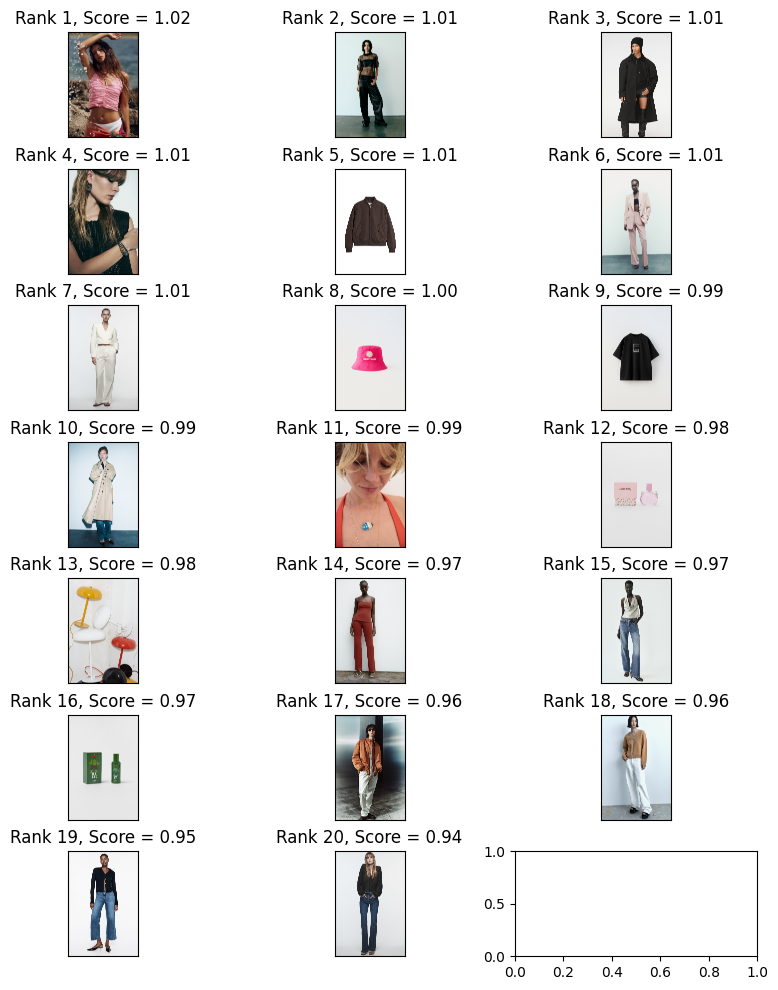

In [59]:
# Sort images and scores by descending order of scores and select the top max_images
sorted_data = sorted(response[0], key=lambda x: x.distance, reverse=True)

# Create a grid of subplots to display the images
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))

# Loop through the top max_images images and display them in the subplots
for i, response in enumerate(sorted_data):
    image_path = f"{image_directory}/{response.id}"
    score = response.distance

    # Calculate the row and column index for the current image
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Display the image in the current subplot
    if os.path.exists(image_path):
        image = copy.deepcopy(Image.open(image_path))
        axs[row_idx, col_idx].imshow(image, cmap="gray")

        # Set the title of the subplot to the image index and score
        axs[row_idx, col_idx].set_title(f"Rank {i+1}, Score = {score:.2f}")

        # Remove ticks from the subplot
        axs[row_idx, col_idx].set_xticks([])
        axs[row_idx, col_idx].set_yticks([])

# Adjust the spacing between subplots and display the plot
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()


# Gradio

In [21]:
INDEX_RESOURCE_NAME = "projects/899604603048/locations/us-central1/indexes/1411179193785384960"

Create function to execute the search

In [2]:
def find_images(query_images):
    NUM_NEIGHBOURS = 6
    num_rows = 3
    num_cols = 2
    query_images = f"{query_images}"
    test_embeddings = encode_texts_to_embeddings(text=[query_images])
    response = my_index_endpoint.find_neighbors(
        deployed_index_id=DEPLOYED_INDEX_ID,
        queries=test_embeddings,
        num_neighbors=NUM_NEIGHBOURS,
        filter=[Namespace("class", ["rebajas"])],
    #    filter=[Namespace("class", ["verano"])],
    )
    response

    # Sort images and scores by descending order of scores and select the top max_images
    sorted_data = sorted(response[0], key=lambda x: x.distance, reverse=True)

    # Create a grid of subplots to display the images
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))

    # Loop through the top max_images images and display them in the subplots
    for i, response in enumerate(sorted_data):
        image_path = f"{image_directory}/{response.id}"
        score = response.distance

        # Calculate the row and column index for the current image
        row_idx = i // num_cols
        col_idx = i % num_cols

        # Display the image in the current subplot
        if os.path.exists(image_path):
            image = copy.deepcopy(Image.open(image_path))
            axs[row_idx, col_idx].imshow(image, cmap="gray")

            # Set the title of the subplot to the image index and score
            axs[row_idx, col_idx].set_title(f"Rank {i+1}, Score = {score:.2f}")

            # Remove ticks from the subplot
            axs[row_idx, col_idx].set_xticks([])
            axs[row_idx, col_idx].set_yticks([])

    # Adjust the spacing between subplots and display the plot
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    plt.show()


In [3]:
find_images("redes jacket")

NameError: ignored

In [6]:
import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown(
    """
    # **Image Search Experience**
    """)

    with gr.Tab("Search image"):
      with gr.Row() as asktext:
        with gr.Column():
          image_text = gr.Textbox(label="Describe image", placeholder="New york year 1950")
      with gr.Row():
        searchImages = gr.Button("Search Image")
      with gr.Row() as output:
        with gr.Column(scale=1, min_width=600):
          output = gr.Image(label="Output")
      searchImages.click(find_images, image_text, output)

demo.launch(server_name="0.0.0.0",share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://a5bd8488d4748f4b23.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 456, in call_prediction
    output = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 232, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1522, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1144, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    re

Keyboard interruption in main thread... closing server.
Killing tunnel 0.0.0.0:7860 <> https://a5bd8488d4748f4b23.gradio.live
